In [2]:
import numpy as np
import pandas as pd 

In [3]:
data = pd.read_csv('data/mnist_with_anomalies.csv')
data

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
matrix = data.to_numpy()
matrix.shape

(6963, 784)

In [5]:
matrix


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
first = matrix[3093]
first = first.reshape(28,28)

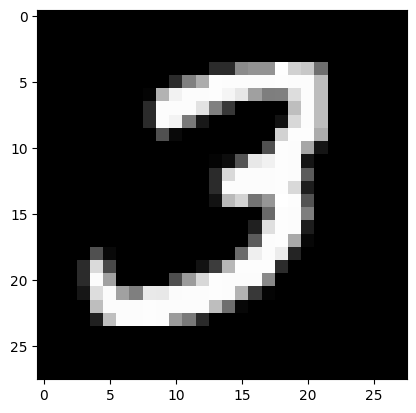

In [7]:
import matplotlib.pyplot as plt

plt.imshow(first, cmap='gray')

In [8]:
anomalies_indices = np.array([81, 143, 223, 329, 352, 401, 663, 701, 712, 790, 863, 2597, 2609, 2658, 2704, 2726, 2781, 3093, 3203, 3295, 6065, 6229, 6235, 6535, 6857])
anomalies_matrix = matrix[anomalies_indices]
def percentage_of_finded_anomalities(found_anomalities, total_anomalities):
    num_of_anomalities = len(total_anomalities)
    count = 0
    for index in found_anomalities:
        if index in total_anomalities:
            count += 1
    return count / num_of_anomalities * 100

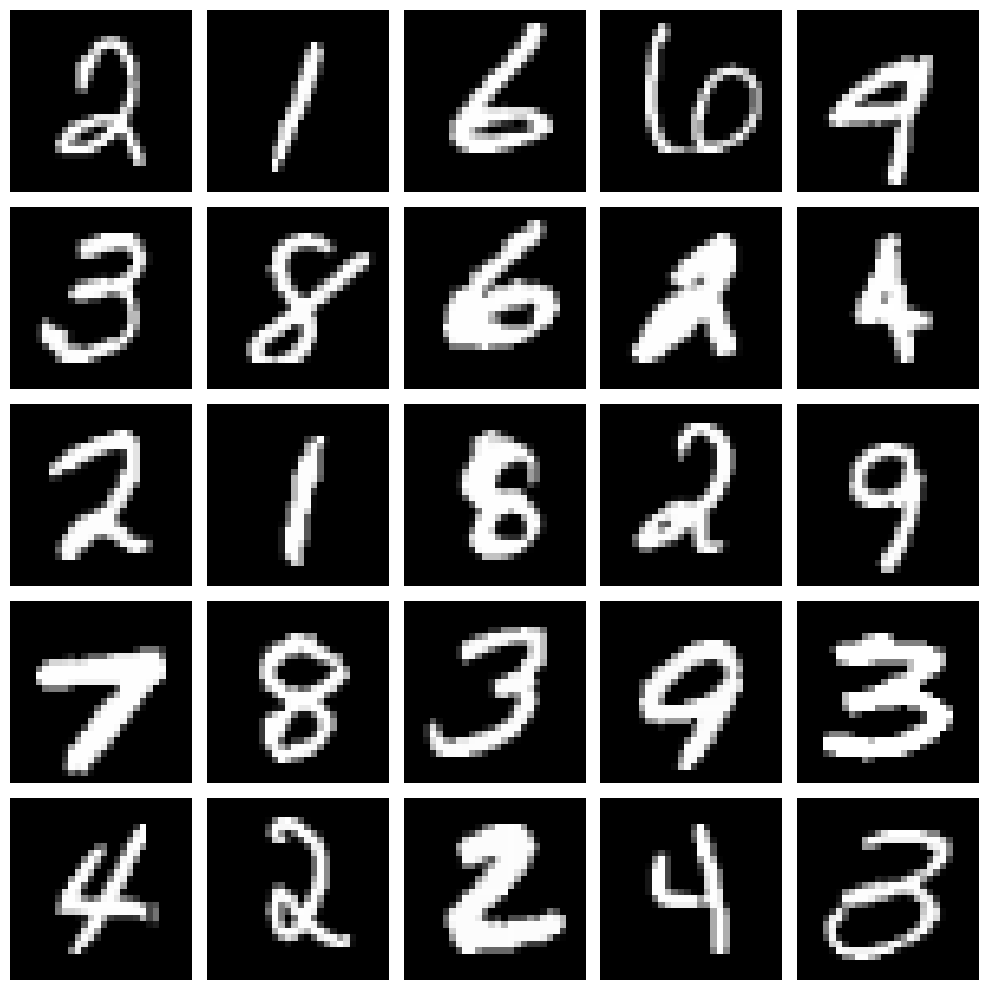

In [9]:
cols = 5
rows = int(np.ceil(len(anomalies_indices) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(axes)):
    if i < len(anomalies_indices):
        axes[i].imshow(anomalies_matrix[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [10]:
from sklearn.decomposition import PCA


pca = PCA(n_components=0.95)

In [11]:
matrix_pca = pca.fit_transform(matrix)



In [12]:
matrix_reconstructed = pca.inverse_transform(matrix_pca)

In [13]:
reconstruction_error = np.mean((matrix - matrix_reconstructed) ** 2, axis=1)

In [14]:
threshold = np.percentile(reconstruction_error, 99.5)

In [15]:
anomalies = np.where(reconstruction_error > threshold)[0]

In [16]:
print("Anomalies detected at indices:", anomalies)


Anomalies detected at indices: [ 223  322  329  352  663  785  945 1328 1369 1378 1421 1501 1506 1721
 1759 2726 3110 3295 3353 3377 3602 3622 3783 3850 4006 4134 4195 4237
 4327 4445 4949 5151 5216 5985 6229]


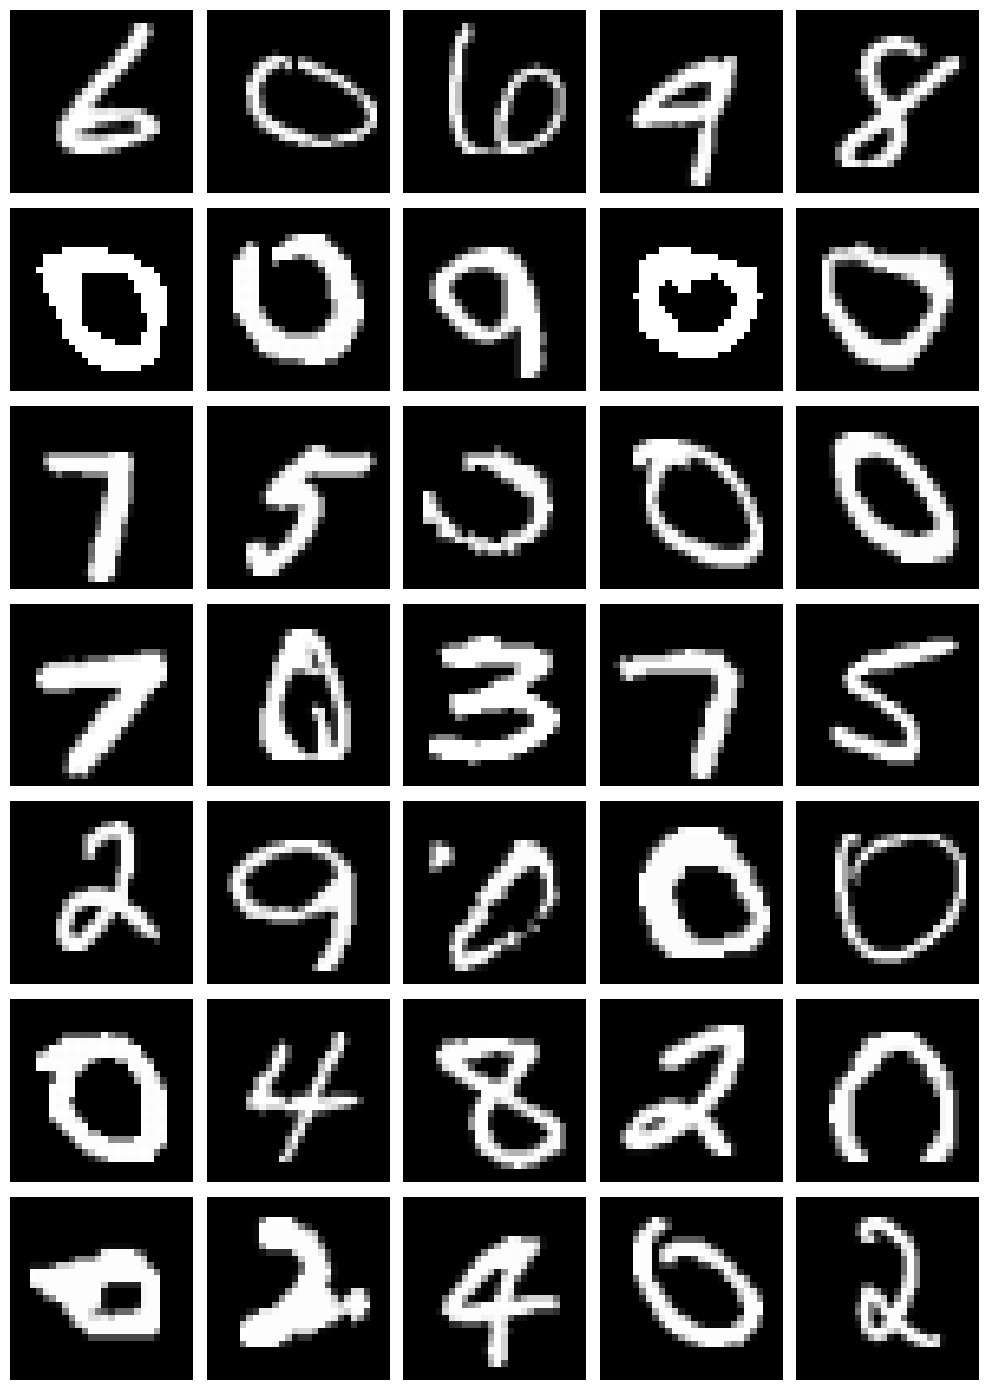

In [17]:
pca_anomaly_matrix = matrix[anomalies].reshape(-1, 28, 28)
num_anomalies = len(pca_anomaly_matrix)
cols = 5
rows = int(np.ceil(num_anomalies / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(axes)):
    if i < num_anomalies:
        axes[i].imshow(pca_anomaly_matrix[i], cmap='gray')
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [18]:
percentage_of_finded_anomalities(anomalies, anomalies_indices)

28.000000000000004

GMM

In [19]:
from sklearn.mixture import GaussianMixture


In [20]:
gmm = GaussianMixture(n_components=5, covariance_type='full', max_iter=1000, init_params='kmeans', random_state=42, tol=1e-8)

In [21]:
gmm.fit(matrix)

GaussianMixture(max_iter=1000, n_components=5, random_state=42, tol=1e-08)

In [22]:
log_likelihood = gmm.score_samples(matrix)


In [23]:
threshold = np.percentile(log_likelihood, 1.7)


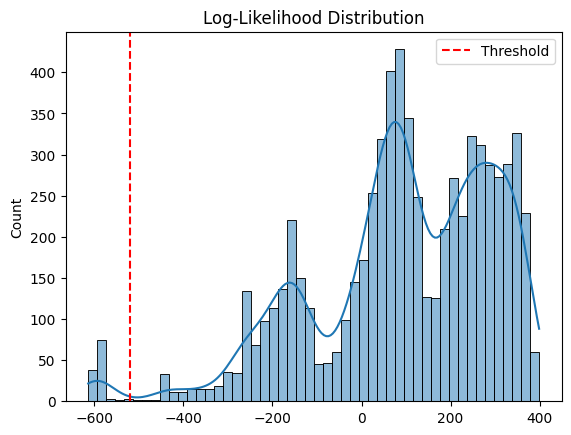

In [24]:
import seaborn as sns

sns.histplot(log_likelihood, bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='dashed', label='Threshold')
plt.legend()
plt.title("Log-Likelihood Distribution")
plt.show()

In [25]:
anomaly_indices = np.where(log_likelihood < threshold)[0]
anomalies = matrix[anomaly_indices]


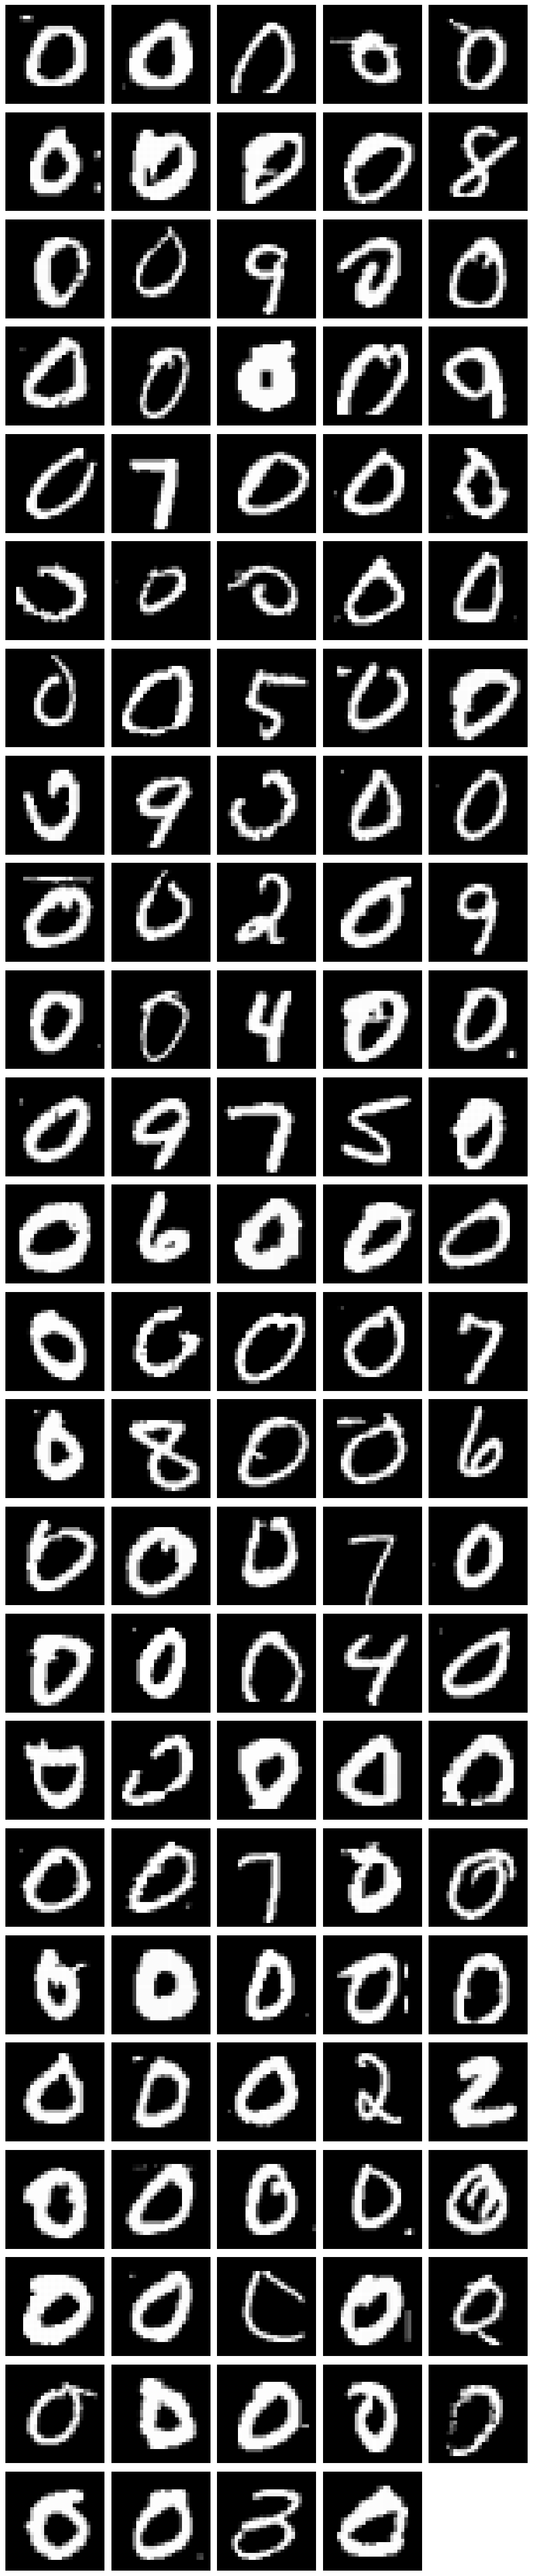

In [26]:
num_anomalies = len(anomaly_indices)
cols = 5
rows = int(np.ceil(num_anomalies / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(axes)):
    if i < num_anomalies:
        axes[i].imshow(anomalies[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [27]:
percentage_of_finded_anomalities(anomaly_indices, anomalies_indices)

28.000000000000004

In [73]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

input_dim = 784
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dropout(0.2)(encoded)  # Dropout برای جلوگیری از overfitting
encoded = Dense(32, activation='relu')(encoded)

# Decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

# Autoencoder Model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [74]:
ae_matrix = matrix / 255.0
autoencoder.fit(ae_matrix, ae_matrix, epochs=100, batch_size=256, shuffle=True, validation_split=0.1)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1612 - val_loss: 0.0930
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0584 - val_loss: 0.0616
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0435 - val_loss: 0.0473
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0382 - val_loss: 0.0391
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0352 - val_loss: 0.0352
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0337 - val_loss: 0.0326
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0322 - val_loss: 0.0307
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0306 - val_loss: 0.0294
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0296 - val_loss: 0.0279
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0287 - val_loss: 0.0264
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0277 - val_loss: 0.0254
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


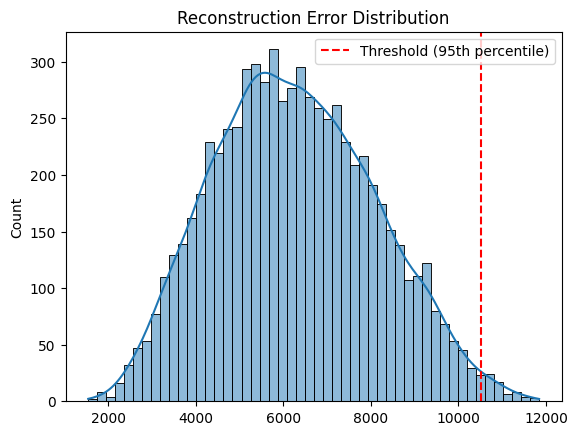

In [75]:
# بازسازی داده‌ها توسط Autoencoder
reconstructed = autoencoder.predict(matrix)

# محاسبه‌ی خطای بازسازی (Mean Squared Error)
reconstruction_error = np.mean((matrix - reconstructed) ** 2, axis=1)

# نمایش توزیع خطای بازسازی
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(reconstruction_error, bins=50, kde=True)
plt.axvline(np.percentile(reconstruction_error, 99), color='red', linestyle='dashed', label='Threshold (95th percentile)')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()


In [76]:
# تعیین آستانه (۵٪ از داده‌ها را به‌عنوان ناهنجاری در نظر بگیریم)
threshold = np.percentile(reconstruction_error, 99)

# پیدا کردن ایندکس ناهنجاری‌ها
anomaly_indices = np.where(reconstruction_error > threshold)[0]

# استخراج تصاویر ناهنجاری
anomalies = matrix[anomaly_indices]

print(f"Detected {len(anomalies)} anomalies out of {len(matrix)} samples")


Detected 70 anomalies out of 6963 samples


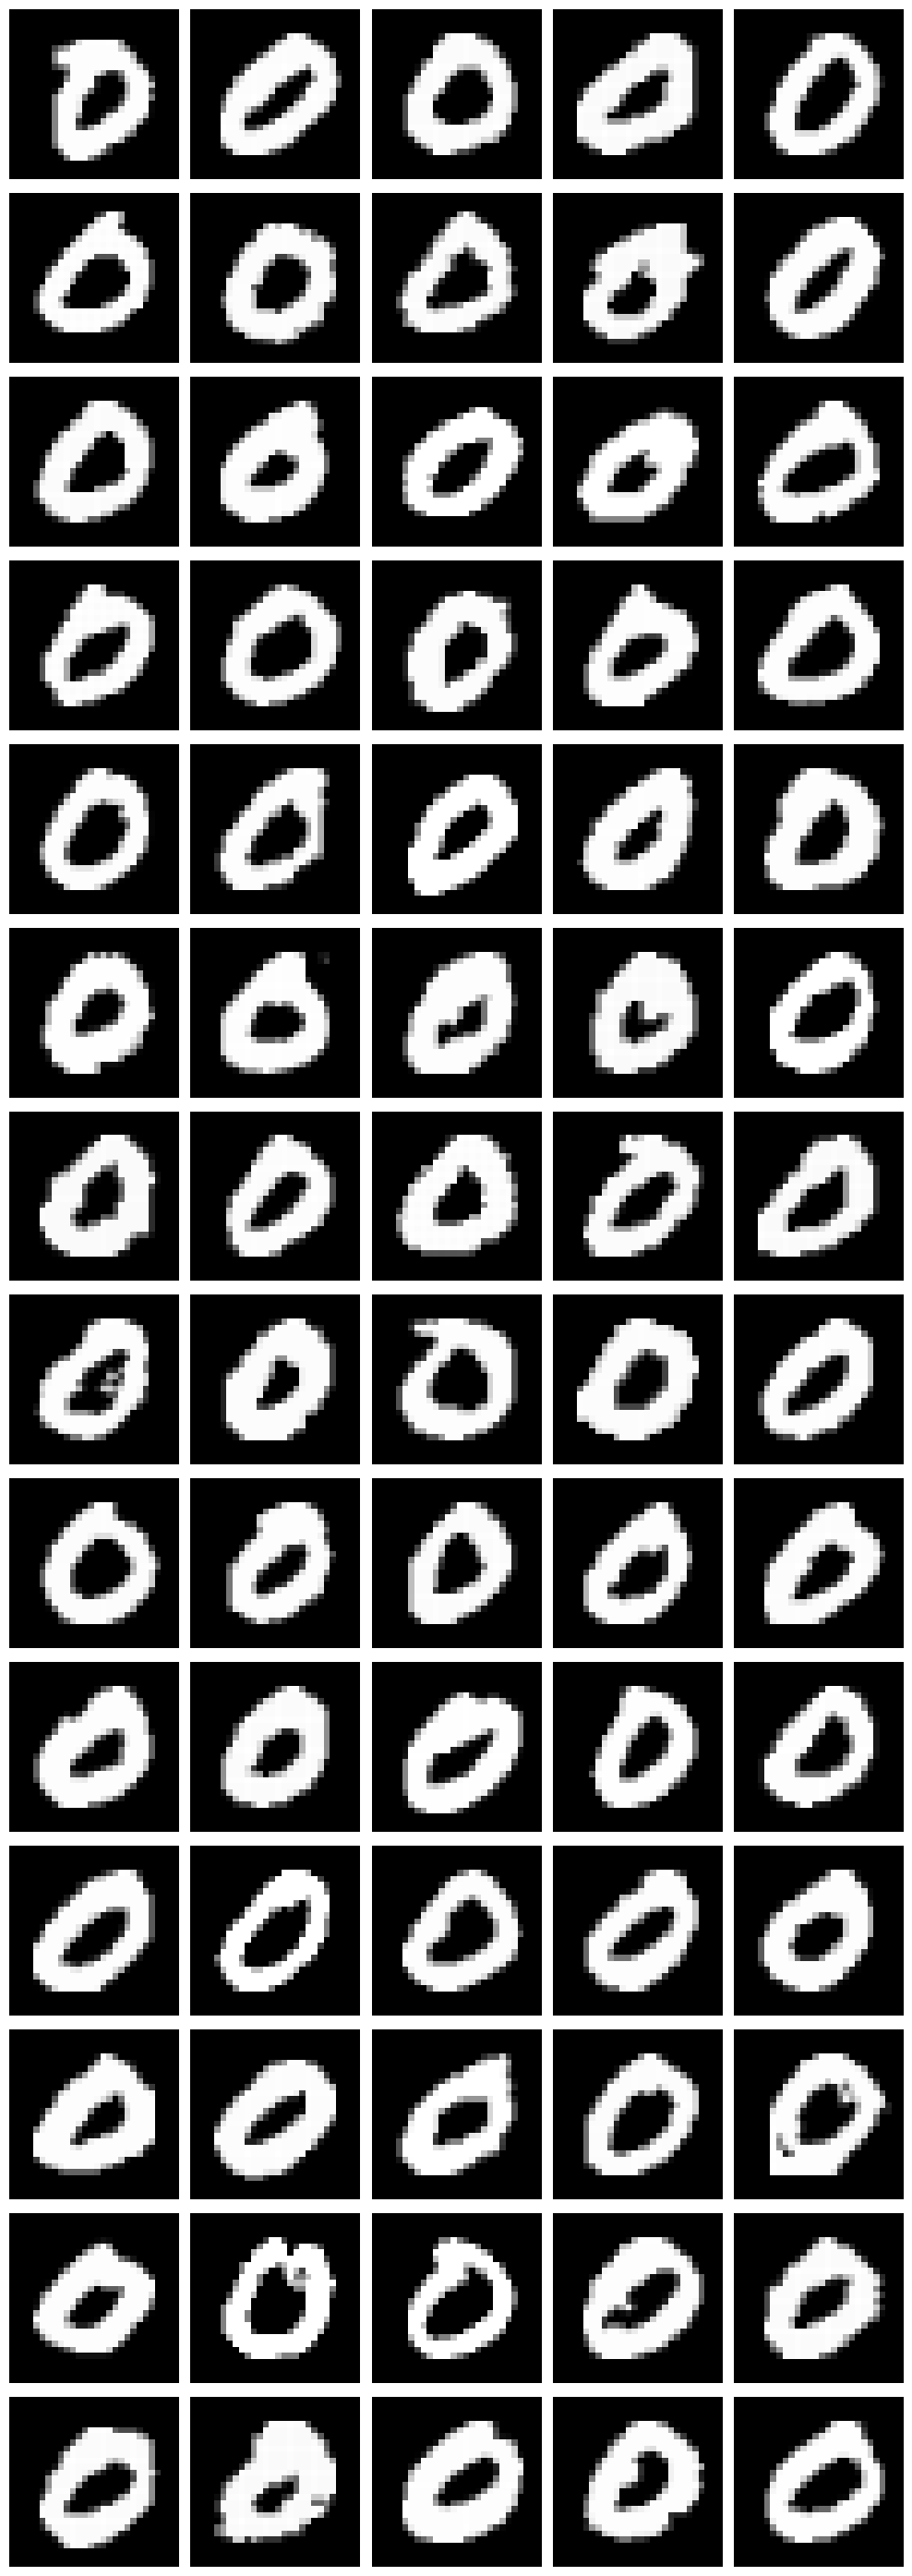

In [77]:
num_anomalies = len(anomalies)
cols = 5
rows = int(np.ceil(num_anomalies / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(axes)):  
    if i < num_anomalies:
        axes[i].imshow(anomalies[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from tensorflow.keras.models import Model

input_dim = (28, 28, 1)
input_layer = Input(shape=input_dim)

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)  
# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Cropping2D(((2, 2), (2, 2)))(x)  

decoded = Conv2D(1, (3, 3), activation="linear", padding='same')(x)  # خروجی 28×28×1

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

cnn_matrix = matrix.reshape(-1, 28, 28, 1) / 255.0
autoencoder.fit(cnn_matrix, cnn_matrix, epochs=100, batch_size=256, shuffle=True, validation_split=0.1)







Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 424ms/step - loss: 0.1075 - val_loss: 0.0560
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - loss: 0.0501 - val_loss: 0.0367
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step - loss: 0.0332 - val_loss: 0.0290
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step - loss: 0.0248 - val_loss: 0.0202
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step - loss: 0.0193 - val_loss: 0.0182
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 407ms/step - loss: 0.0172 - val_loss: 0.0155
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - loss: 0.0153 - val_loss: 0.0144
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 411ms/step - loss: 0.0142 - val_loss: 0.0135
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 411ms/step - loss: 0.0127 - val_loss: 0.0122
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - loss: 0.0122 - val_loss: 0.0123
Epoch 12/100
25/25 ━━━━━━━━━━━

218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


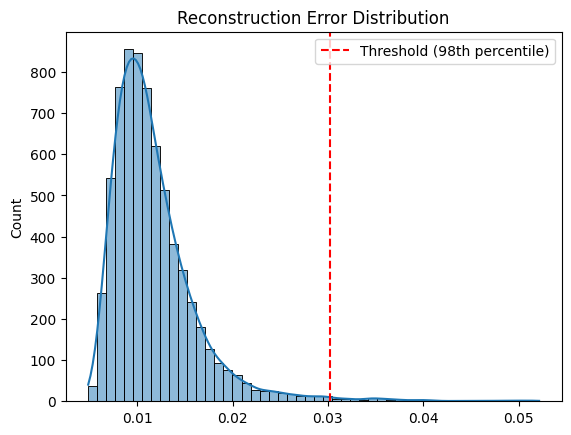

In [79]:
reconstructed = autoencoder.predict(cnn_matrix)

# محاسبه خطای بازسازی
reconstruction_error = np.mean((cnn_matrix - reconstructed) ** 2, axis=(1, 2, 3))

# نمایش توزیع خطای بازسازی
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(reconstruction_error, bins=50, kde=True)
plt.axvline(np.percentile(reconstruction_error, 99), color='red', linestyle='dashed', label='Threshold (98th percentile)')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()

Detected 105 anomalies out of 6963 samples


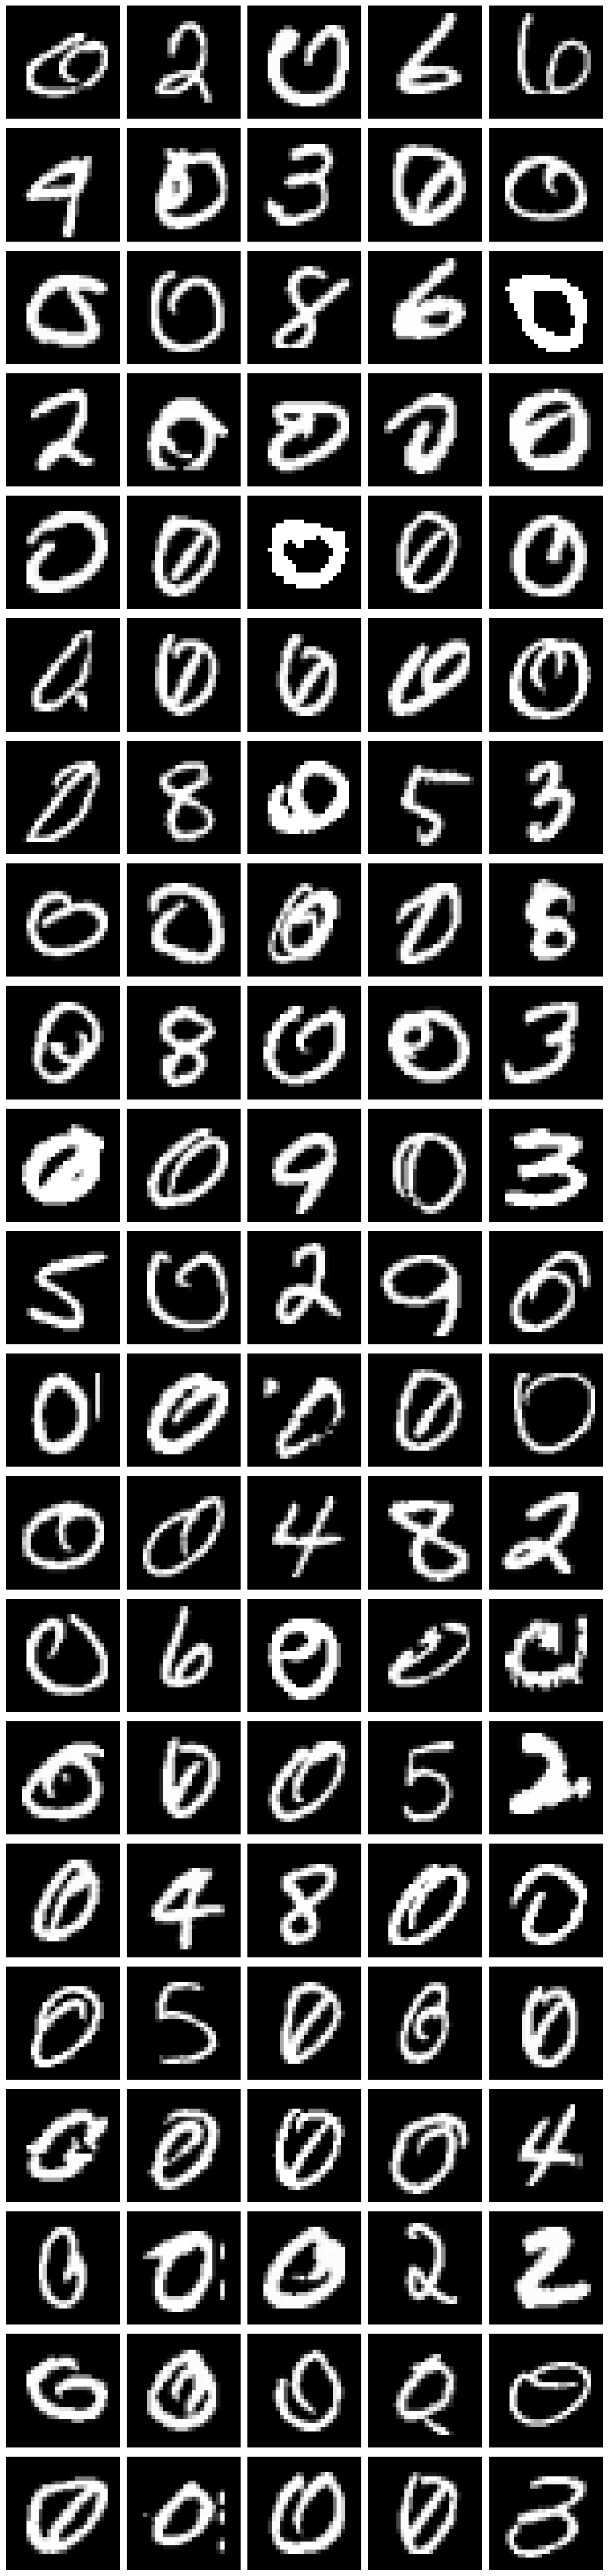

In [80]:
threshold = np.percentile(reconstruction_error, 98.5)
anomaly_indices = np.where(reconstruction_error > threshold)[0]
anomalies = cnn_matrix[anomaly_indices]

print(f"Detected {len(anomalies)} anomalies out of {len(cnn_matrix)} samples")

# نمایش تصاویر ناهنجاری
num_anomalies = len(anomalies)
cols = 5
rows = int(np.ceil(num_anomalies / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for i in range(len(axes)):
    if i < num_anomalies:
        axes[i].imshow(anomalies[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()